new_script/numeric_int/ATP_MM_new/!20190612 500nM Bep1 150uM Rac1 3200uM ATP001/12062019001.res


/struct/soft/osx/anaconda/5.3.0/lib/python2.7/site-packages/ipykernel_launcher.py:128: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


('channels:', {u'280': u'UV2_280nm', u'260': u'UV1_260nm'})
new_script/numeric_int/ATP_MM_new/!20190612 500nM Bep1 150uM Rac1 3200uM ATP001/12062019002.res
('channels:', {u'280': u'UV2_280nm', u'260': u'UV1_260nm'})
new_script/numeric_int/ATP_MM_new/!20190612 500nM Bep1 150uM Rac1 3200uM ATP001/12062019003.res
('channels:', {u'280': u'UV2_280nm', u'260': u'UV1_260nm'})
new_script/numeric_int/ATP_MM_new/!20190612 500nM Bep1 150uM Rac1 3200uM ATP001/12062019004.res
('channels:', {u'280': u'UV2_280nm', u'260': u'UV1_260nm'})
new_script/numeric_int/ATP_MM_new/!20190612 500nM Bep1 150uM Rac1 3200uM ATP001/12062019005.res
('channels:', {u'280': u'UV2_280nm', u'260': u'UV1_260nm'})
new_script/numeric_int/ATP_MM_new/!20190612 500nM Bep1 150uM Rac1 3200uM ATP001/12062019006.res
('channels:', {u'280': u'UV2_280nm', u'260': u'UV1_260nm'})
{'Run Name': 'new_script', 'Sample Name': u'12062019001', 'Method Start Time': datetime.datetime(2019, 6, 12, 23, 26, 9)}
Index([u'260'], dtype='object')
{'Run 

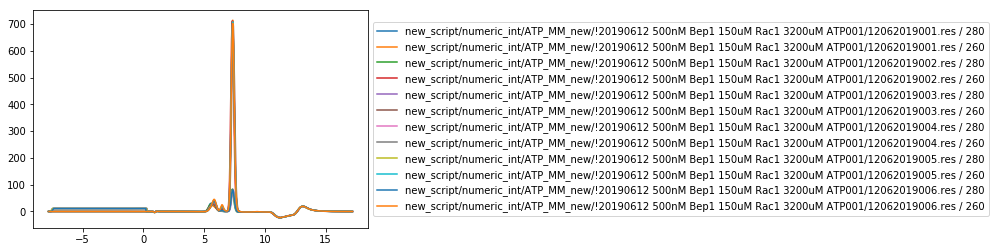

In [1]:
### Aekta Unicorn plotting

import os
import pandas as pd
from pycorn import pc_uni6
from pycorn import pc_res3
import xml.etree.ElementTree as ET
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

class FPLCMethod:

    def __init__(self, fplc_file, selected_channels = ["260","280"], uni_version="uni6"):
        
        self.properties = {}
        self.channels = []
        self.file_name = fplc_file
        
        if uni_version == 'uni6':
            self.load_uni6(fplc_file)
        if uni_version == 'uni3':
            self.load_uni3(fplc_file)
        
        available_channels = self.channels.keys()
        #print(available_channels)
        used_channels = list(set(selected_channels).intersection(available_channels))
        self.channels = dict((key,self.channels[key]) for key in self.channels if key in used_channels)
        
        if len(self.channels) <= 0:
            print("Selected channels are not available!")
            print("selected:", selected_channels)
            print("available:", available_channels)
            self.data_frame = None
        else:
            if len(self.channels) < len(selected_channels):
                print("selected Channels:", selected_channels)
                print("available Channels:", available_channels)
                print("Channels to be used", self.channels.keys())
            self.data_frame = self.get_dataframe(self.data, self.channels, uni_version)
            self.data_frame.to_excel(os.path.splitext(fplc_file)[0]+".xlsx")    
            
            with open(os.path.splitext(fplc_file)[0]+".properties", "w") as property_file:                
                property_file.write('proptest = ' + str(self.properties))
                         

        print("channels:", self.channels)
        #print("properties:", self.properties)
        
    def load_uni6(self,fplc_file):
        try:
            self.data = pc_uni6(fplc_file)
            self.data.load()
        except:
            print("Problem decoding file:", self.file_name)
        self.channels, self.properties["Method Start Time"] = self.get_chromatogram_properties(self.data["Chrom.1.Xml"])
        self.properties.update(self.get_run_properties(self.data["Result.xml"]))
            
    def load_uni3(self,fplc_file):
        try:
            self.data = pc_res3(fplc_file)
            self.data.load()
        except:
            print("Problem decoding file:", self.file_name)

        channels = {}
        for key in self.data.keys():
            if "UV" in key:
                channels[key[4:7]] = key
        self.channels = channels  
        self.properties["Sample Name"] = self.data['Logbook']['run_name']
        self.properties["Run Name"] = fplc_file.split("/")[0]
        self.properties["Method Start Time"] = datetime.datetime.strptime(self.data['Logbook']['data'][0][1][11:31], "%d.%m.%Y, %H:%M:%S")
        
    def get_chromatogram_properties(self, XML):
        channels ={}
        root = ET.fromstring(XML)
        curves = root.find("Curves").findall("Curve")
        curve = [c for c in curves if c.attrib["CurveDataType"] == "UV"]
        for c in curve:
            channel = c.find("Name").text[-3:]
            pts = c.find("CurvePoints")
            pt = pts.find("CurvePoint")
            channel_file = pt.find("BinaryCurvePointsFileName")
            channels[channel] = channel_file.text
        if len(channels) > 0:
            method_start = datetime.datetime.strptime(curves[0].find("MethodStartTime").text,"%Y-%m-%dT%H:%M:%S.%f")
        return(channels, method_start)

    def get_run_properties(self, XML):
        root = ET.fromstring(XML)
        p = {}
        p["Sample Name"] = root.find("Name").text
        p["Run Name"] = root.find("FolderPath").text.split("/")[-1]
        return(p)

    def get_primary_channel(self, df):
        channel_data_length = dict((c,len(df[c])) for c in df)
        return(max(channel_data_length, key=channel_data_length.get))

    def get_dataframe(self, data, channels, uni_version):
        
        """ returns a processed data frame. The first column is a list of timepoints. 
            The subsequent columns are absorbance values for each available channel """
    
        df = {}
    
        for c in channels:
            values = {}
            if uni_version == 'uni6':
                x = data[channels[c]]["CoordinateData.Volumes"]
                y = data[channels[c]]["CoordinateData.Amplitudes"]
            elif uni_version == 'uni3':              
                x,y = zip(*data[channels[c]]['data'])
            else:
                x,y = None
            values["Volume"] = x
            values[c] = y
            values_df = pd.DataFrame(values)
            # remove duplicate key values (=Volume)
            df[c] = values_df.groupby((values_df["Volume"] != values_df["Volume"].shift()).cumsum().values).first()
    
        primary_channel = self.get_primary_channel(df)
        merged_df = df[primary_channel]
        for c in df:
            if c != primary_channel:
                merged_df = merged_df.merge(df[c], on="Volume", how="left")
        merged_df = merged_df.reindex_axis(sorted(merged_df.columns, reverse=True), axis=1)
        return(merged_df)
    
    def plot(self):
#        plt.clf()
        if self.data_frame is not None:
            print(self.properties)
            df = self.data_frame.dropna()
            print(df.columns[2:])
            for channel in df.columns[1:]:
                plt.plot(df["Volume"], df[channel],label=" / ".join([self.file_name, channel]))
#            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#            plt.show()
        
            
def list_files(path, filetypes):
    data_files =[]
    for f in sorted(os.listdir(path)):
        if f.endswith(tuple(filetypes)):
            data_files.append(os.path.join(path,f))
    return(data_files)
        
def import_FPLCRuns(in_dir, selected_channels=["260","280"]):
                
    file_names = list_files(in_dir, ["zip", "res"])    
    FPLC_runs = []
        
    for f in file_names:
        print(f)
        if f[-4:].lower() == ".res":
            uni_v = "uni3"
        elif f[-4:].lower() == ".zip":
            uni_v = "uni6"
        else:
            print("Can not process unsuported Filetype:", f[-4:].lower())
            return(None)
        m = FPLCMethod(f, selected_channels, uni_version=uni_v)
        FPLC_runs.append(m)
    return(FPLC_runs)


#in_dir = "20180711_100uM_Rac1_1600uM_ATP_400uM_P1P5/"
in_dir = os.path.join('new_script', 'numeric_int', 'ATP_MM_new','!20190612 500nM Bep1 150uM Rac1 3200uM ATP001')

chromatograms = import_FPLCRuns(in_dir)
plt.clf()
for c in chromatograms:
    c.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()